In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
from dataclasses import dataclass
import glob
import cv2

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model

from keras.models import Model, Sequential
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import gc
import warnings
warnings.filterwarnings("ignore")

In [2]:
@dataclass
class CONFIG:
    IMAGES_DIRECTORY = "/kaggle/input/plantvillage-dataset/color/"
    IMAGE_SIZE = (256, 256)
    IMAGE_SHAPE = (256, 256, 3)
    BATCH_SIZE = 128
    DROPOUT = 0.25
    LEARNING_RATE = 0.001
    EPOCHS = 30
    MODEL_NAMES = ["vgg16", "inceptionv3", "densenet169", "mobilenetv2"]
    RANDOM_SEED = 42

def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
def set_global_determinism(seed):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
    
    print("All seeds set succesfully")
        
def collect_garbage():
    gc.collect()
    print("Garbage collection done")
    
set_global_determinism(CONFIG.RANDOM_SEED)

All seeds set succesfully


In [3]:
image_filepaths_list = []
labels_list = []

for image_filepath in glob.glob(CONFIG.IMAGES_DIRECTORY + "*/*"):
    image_filepaths_list.append(image_filepath)
    label = image_filepath.split("/")[-2]
    labels_list.append(label)
    
print(f"Total number of images: {len(image_filepaths_list)}")
print(f"Total number of images: {len(labels_list)}")

Total number of images: 54305
Total number of images: 54305


In [4]:
df = pd.DataFrame({
    "image_filepaths": image_filepaths_list,
    "labels": labels_list
})

assert len(image_filepaths_list) == len(labels_list) == len(df)

df

image_filepaths  \
0      /kaggle/input/plantvillage-dataset/color/Tomat...   
1      /kaggle/input/plantvillage-dataset/color/Tomat...   
2      /kaggle/input/plantvillage-dataset/color/Tomat...   
3      /kaggle/input/plantvillage-dataset/color/Tomat...   
4      /kaggle/input/plantvillage-dataset/color/Tomat...   
...                                                  ...   
54300  /kaggle/input/plantvillage-dataset/color/Corn_...   
54301  /kaggle/input/plantvillage-dataset/color/Corn_...   
54302  /kaggle/input/plantvillage-dataset/color/Corn_...   
54303  /kaggle/input/plantvillage-dataset/color/Corn_...   
54304  /kaggle/input/plantvillage-dataset/color/Corn_...   

                       labels  
0        Tomato___Late_blight  
1        Tomato___Late_blight  
2        Tomato___Late_blight  
3        Tomato___Late_blight  
4        Tomato___Late_blight  
...                       ...  
54300  Corn_(maize)___healthy  
54301  Corn_(maize)___healthy  
54302  Corn_(maize)___healthy  
54303  Corn_(maize)___healthy  
54304  Corn_(maize)___healthy  

[54305 rows x 2 columns]

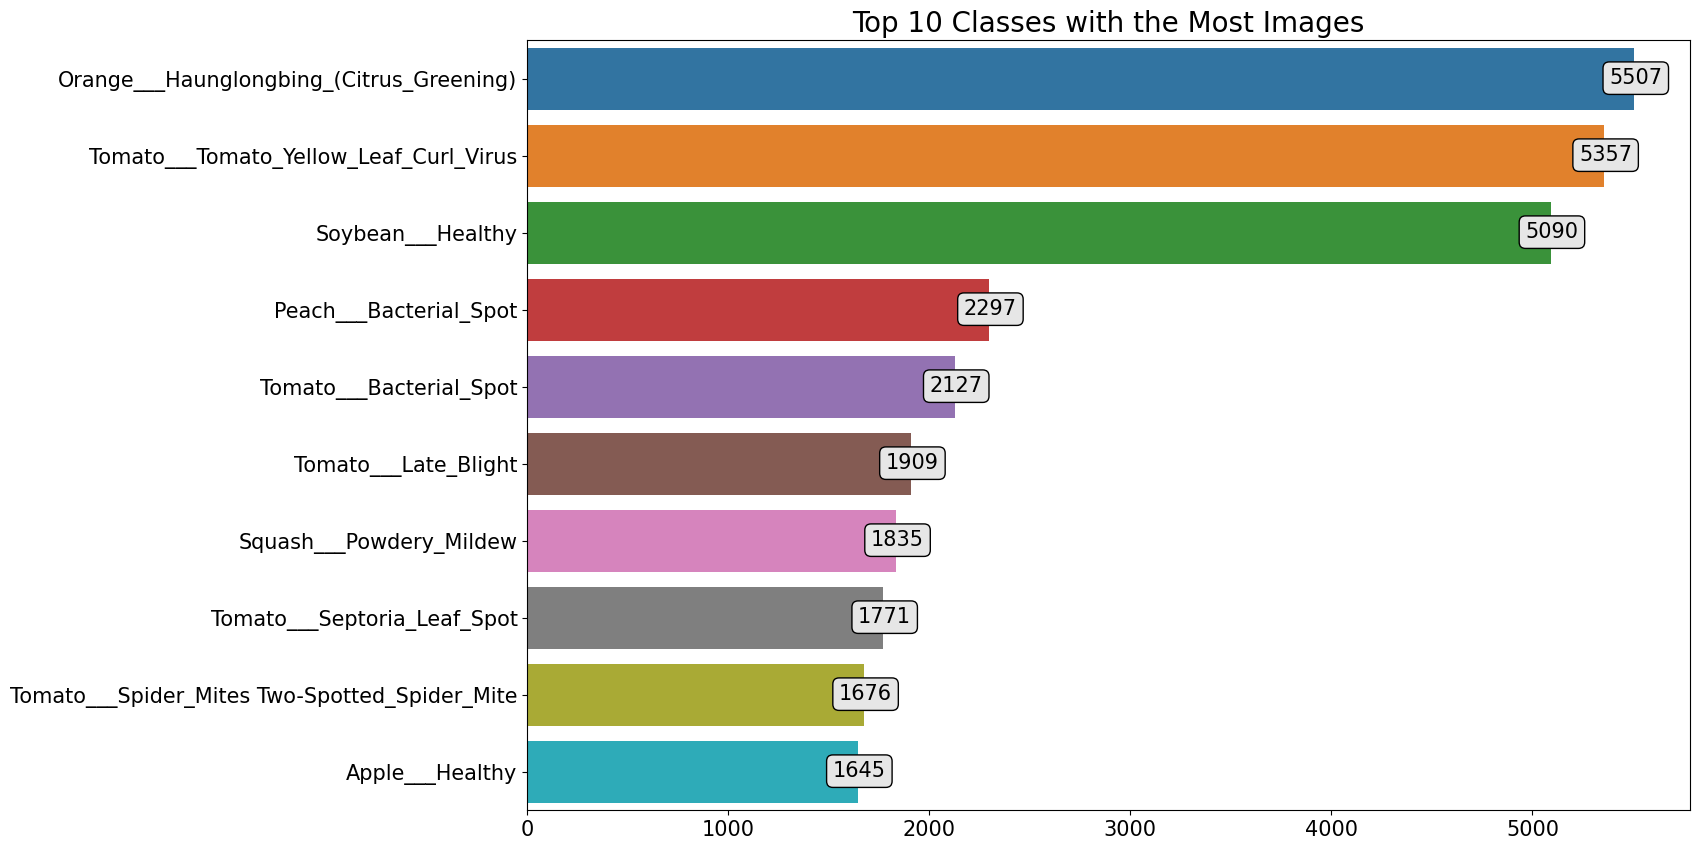

In [5]:
keys = df['labels'].value_counts().index.tolist()[0:10]
keys = [plant.title() for plant in keys]
values = df['labels'].value_counts().to_list()[0:10]
plt.figure(figsize = (15, 10))
ax = sns.barplot(x = values, y = keys)
plt.title('Top 10 Classes with the Most Images', fontsize = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)

bbox_args = dict(boxstyle = 'round', fc = '0.9')
for p in ax.patches:
    width = p.get_width()
    plt.text(7 + p.get_width(), p.get_y() + 0.49 * p.get_height(),
             '{:.0f}'.format(width),
             ha='center', va='center',
             color = 'black',
             bbox = bbox_args,
             fontsize = 15)

plt.show()

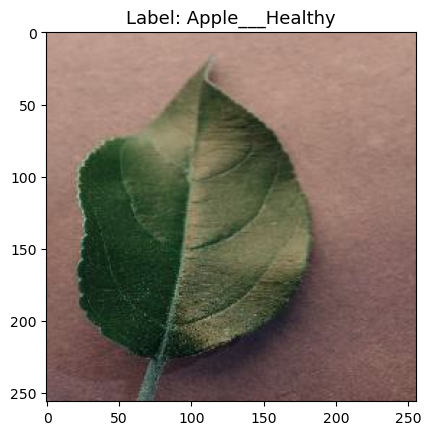

In [6]:
def plot_random_image(df):
    
    random_number = random.randint(0, len(df))
    
    img = cv2.imread(df["image_filepaths"][random_number])
    label = df["labels"][random_number]
    
    plt.title(f"Label: {label.title()}", fontsize=13)
    plt.imshow(img)
    plt.show()
    
plot_random_image(df)

In [7]:
X_train, X_rem, y_train, y_rem = train_test_split(df["image_filepaths"], df["labels"], test_size=0.2, stratify=df["labels"])
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, stratify=y_rem)
print(f"X_train length: {len(X_train)}")
print(f"X_val length: {len(X_val)}")
print(f"X_test length: {len(X_test)}")
print(f"y_train length: {len(y_train)}")
print(f"y_val length: {len(y_val)}")
print(f"y_test length: {len(y_test)}")

X_train length: 43444
X_val length: 5430
X_test length: 5431
y_train length: 43444
y_val length: 5430
y_test length: 5431


In [8]:
def make_seperate_dataframes(X, y, type_of_data):
    
    assert len(X) == len(y)
    
    df = pd.DataFrame({
    "image_filepaths": X,
    "labels": y
    })
    
    print(f"{type_of_data.title()} set has {len(X)} samples")
    
    return df

train_df = make_seperate_dataframes(X_train, y_train, "train")
val_df = make_seperate_dataframes(X_val, y_val, "val")
test_df = make_seperate_dataframes(X_test, y_test, "test")

del df, image_filepaths_list, labels_list
collect_garbage()

Train set has 43444 samples
Val set has 5430 samples
Test set has 5431 samples
Garbage collection done


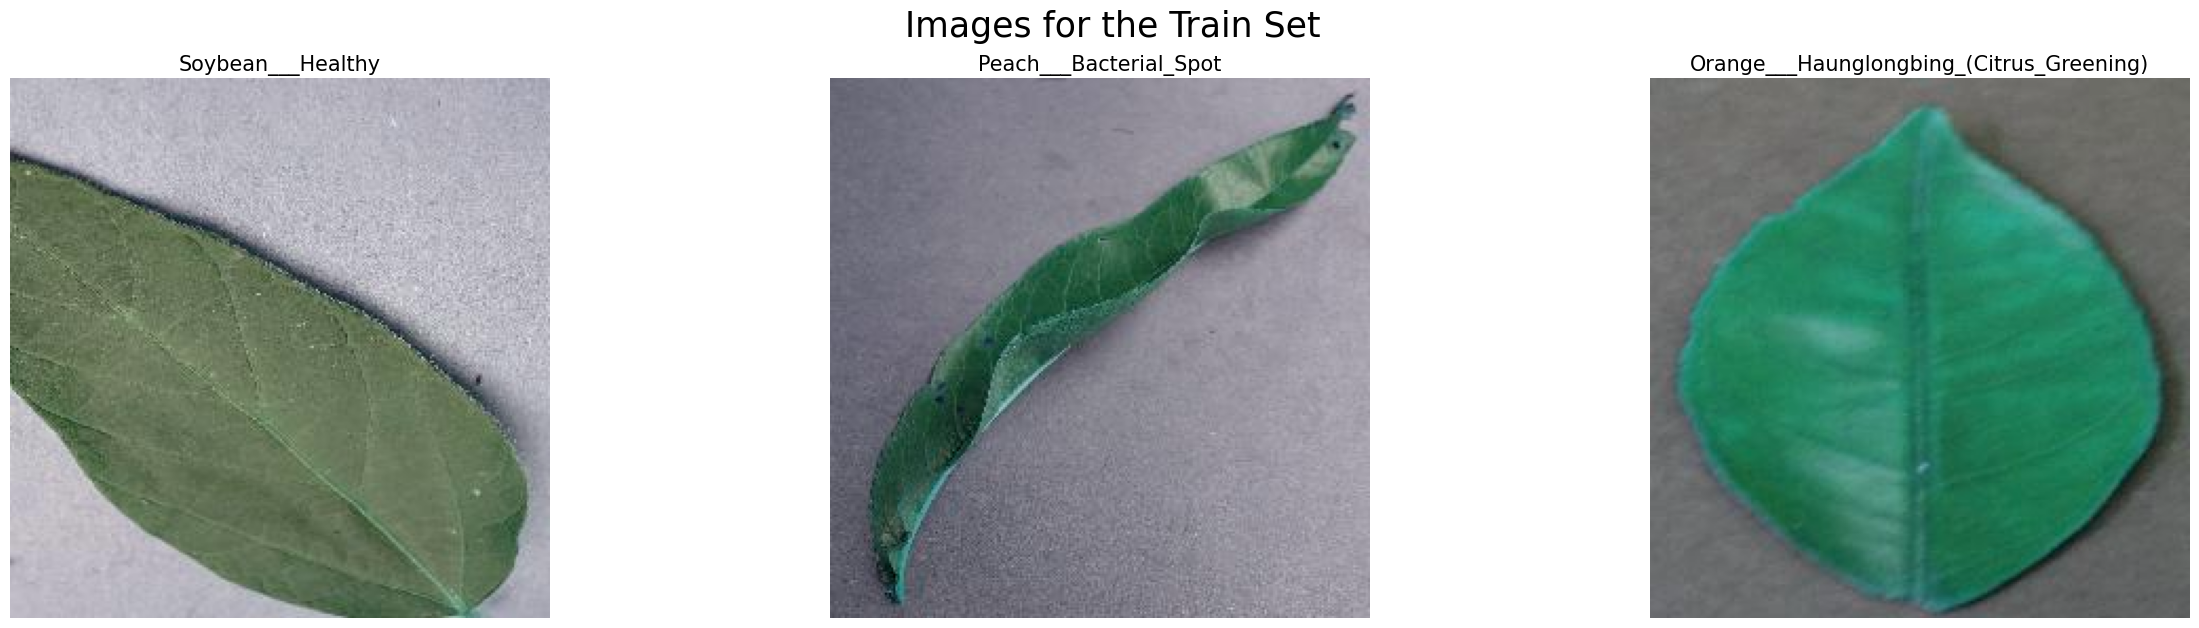

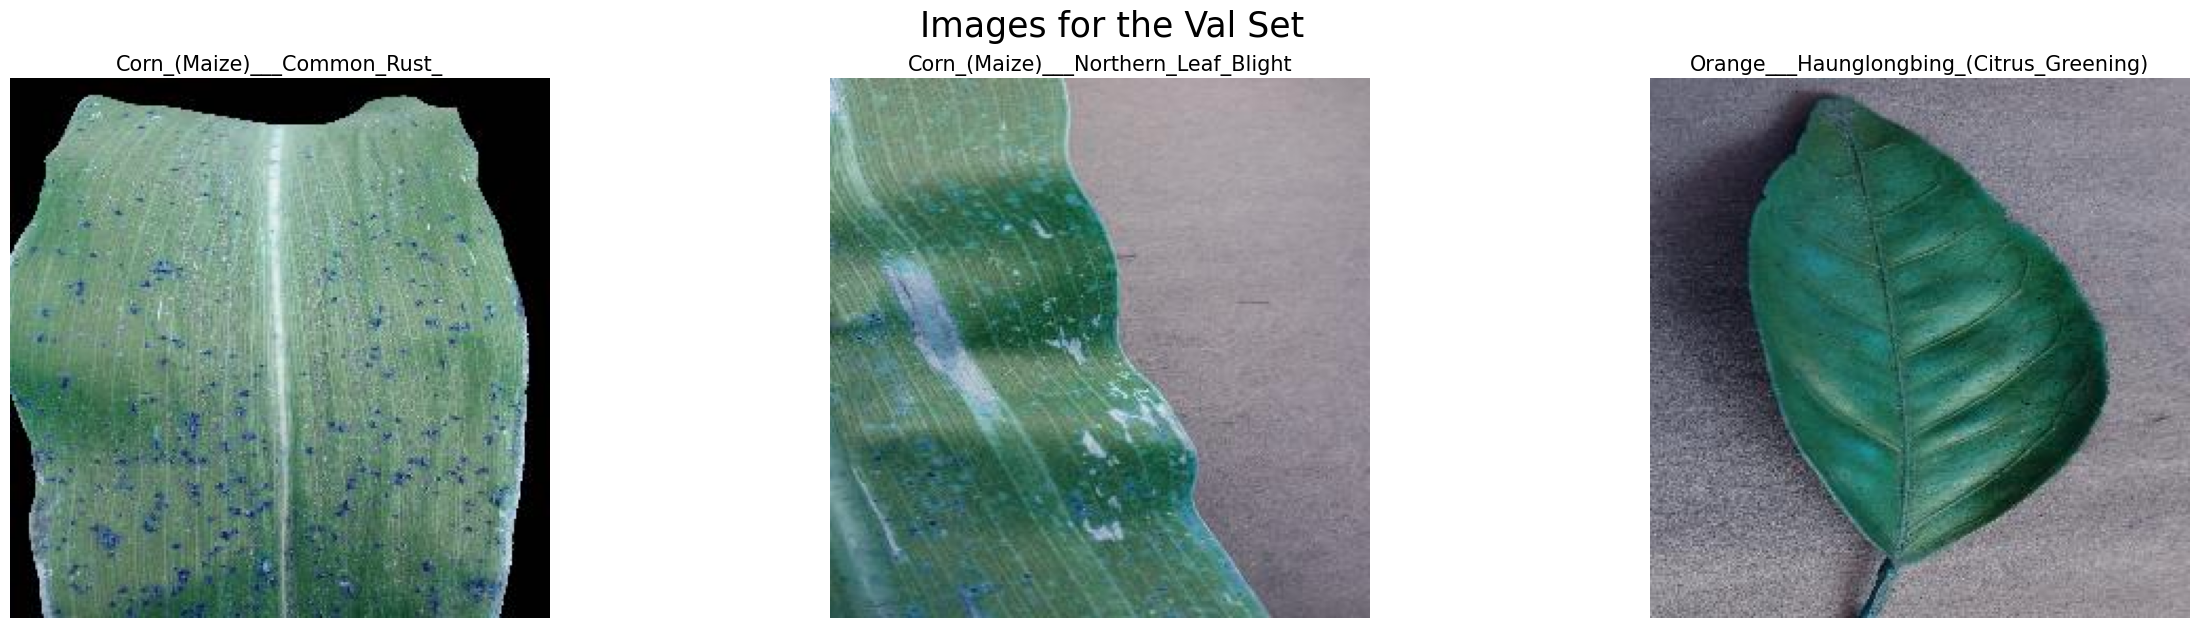

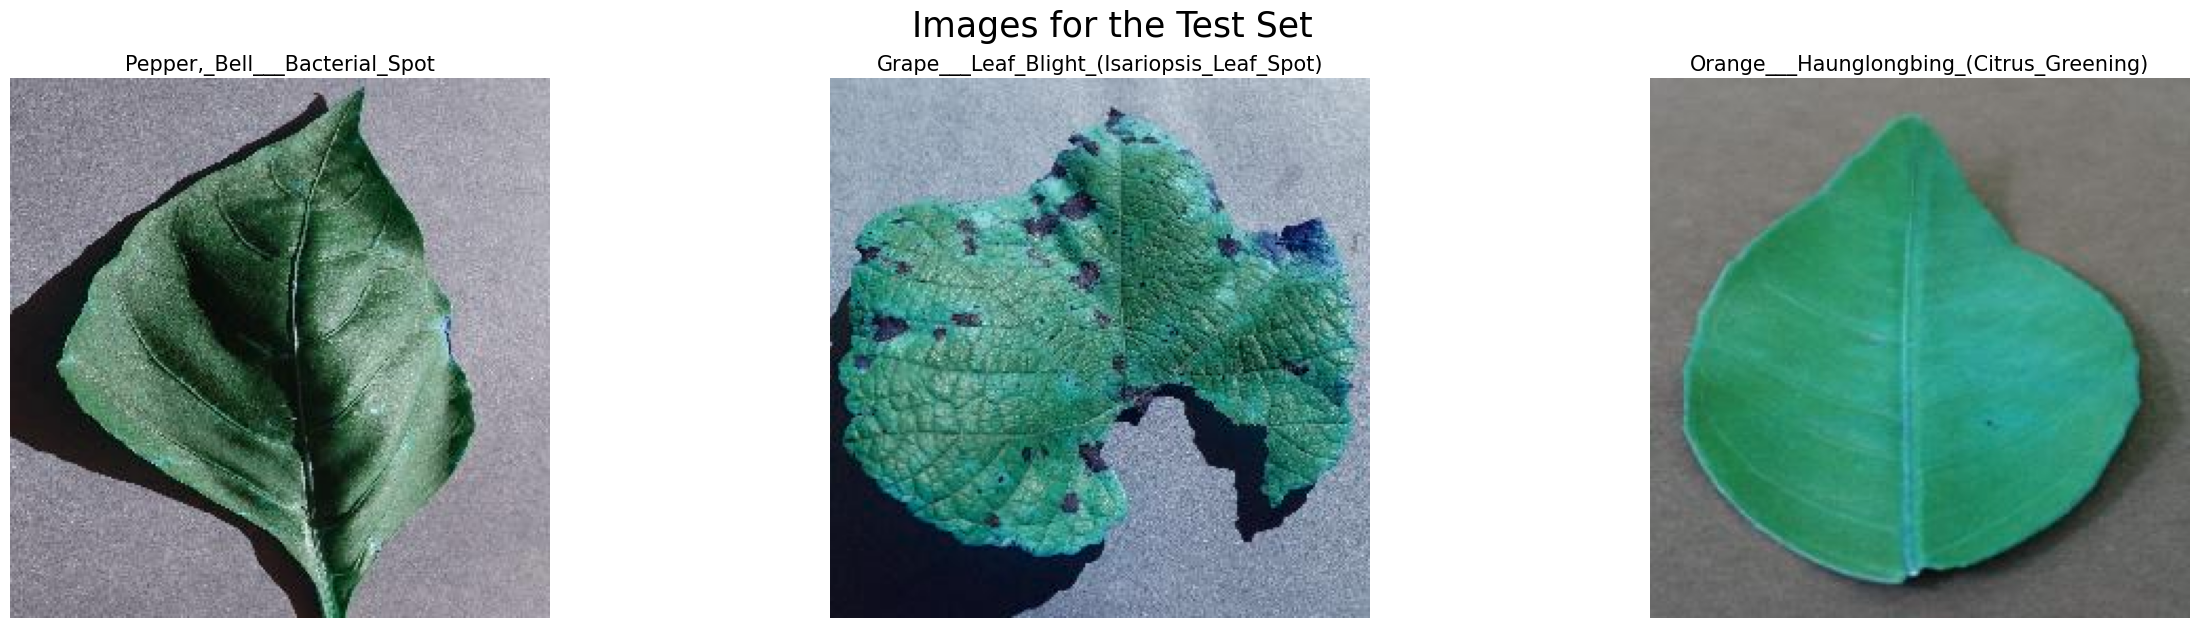

In [9]:
def plot_random_dataset_images(df, type_of_set):
    
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (25, 8))
    
    plt.suptitle('Images for the ' + type_of_set + ' Set', fontsize=25)
    
    random_list = []
    
    for i in range(0, 3):
        random_number = random.randint(0, len(df) - 1)
        random_list.append(random_number)
        
    for i in range(3):
        axes[i].imshow(cv2.imread(df["image_filepaths"][df.index[random_list[i]]]))
        axes[i].set_title(df["labels"][df.index[random_list[i]]].title(), fontsize=15)
        axes[i].axis('off')
        
    plt.tight_layout(rect=[0, 0.2, 0.99, 0.975])
    plt.show()
    print('\n\n')
    
plot_random_dataset_images(train_df, "Train")
plot_random_dataset_images(val_df, "Val")
plot_random_dataset_images(test_df, "Test")

In [10]:
def get_data_generator(type_of_dataset):
    
    if(type_of_dataset == "train"):
        datagen = ImageDataGenerator(rescale = 1 / 255.0,
                                   rotation_range = 15,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')
    
    if((type_of_dataset == "val") or (type_of_dataset == "test")):
        datagen = ImageDataGenerator(rescale = 1 / 255.0)
        
    return datagen

def create_dataset_generators(datagen, df):
    
    data_generator = datagen.flow_from_dataframe(dataframe=df,
                                                x_col="image_filepaths",
                                                y_col="labels",
                                                target_size=CONFIG.IMAGE_SIZE,
                                                batch_size=CONFIG.BATCH_SIZE,
                                                class_model="categorical")
    
    return data_generator

train_datagen = get_data_generator("train")
val_datagen = get_data_generator("val")
test_datagen = get_data_generator("test")

train_generator = create_dataset_generators(train_datagen, train_df)
val_generator = create_dataset_generators(val_datagen, val_df)
test_generator = create_dataset_generators(test_datagen, test_df)

assert train_generator.class_indices == test_generator.class_indices

Found 43444 validated image filenames belonging to 38 classes.
Found 5430 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.


In [11]:
transfer_learning_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False,
                                                            weights="imagenet",
                                                            input_shape=CONFIG.IMAGE_SHAPE)
transfer_learning_model.trainable = False

total_params = transfer_learning_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in transfer_learning_model.trainable_weights])

print(f"There are {total_params} total parameters in the pre-trained VGG16 model")
print(f"There are {num_trainable_params} trainable parameters in this model")

9406464/9406464 [==============================] - 0s 0us/step
There are 2257984 total parameters in the pre-trained VGG16 model
There are 0 trainable parameters in this model


In [12]:
transfer_learning_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [13]:
# plot_model(transfer_learning_model, show_shapes=True)

In [14]:
model = Sequential([
    transfer_learning_model,
    GlobalAveragePooling2D(),
    Dropout(CONFIG.DROPOUT),
    Dense(units=1024, activation="relu"),
    Dense(units=512, activation="relu"),
    BatchNormalization(),
    Dense(units=38, activation="softmax")
])

model.compile(
    loss = "categorical_crossentropy",
    optimizer = keras.optimizers.Adam(learning_rate=CONFIG.LEARNING_RATE),
    metrics = ["acc"]
)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization (BatchN  (None, 512)              2

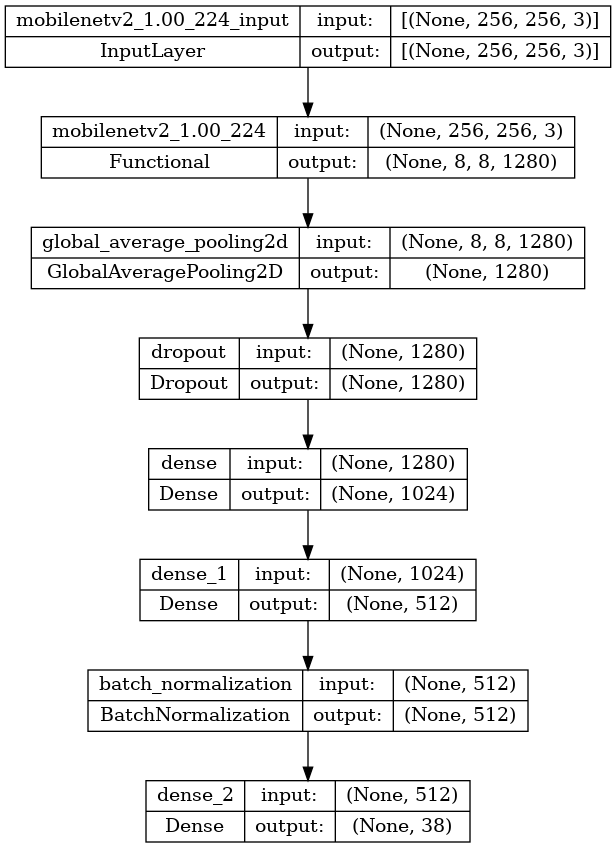

In [16]:
plot_model(model, show_shapes=True)

In [17]:
reduce_lr = ReduceLROnPlateau(monitor="val_acc", patience=2, verbose=1, factor=0.5, min_lr=0.00001)
early_stop = EarlyStopping(monitor="val_acc", patience=3)
model_checkpoint = ModelCheckpoint(f"../working/{CONFIG.MODEL_NAMES[-1]}_epochs_{CONFIG.EPOCHS}_batchsize_{CONFIG.BATCH_SIZE}_lr_{CONFIG.LEARNING_RATE}.h5",
                                   monitor="val_acc", save_best_only=True, mode="max")

In [18]:
%%time

classifier = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=CONFIG.EPOCHS,
    verbose=1,
    callbacks=[reduce_lr, early_stop, model_checkpoint]
)

Epoch 1/30
340/340 [==============================] - 977s 3s/step - loss: 0.4163 - acc: 0.8745 - val_loss: 0.2780 - val_acc: 0.9033 - lr: 0.0010
Epoch 2/30
340/340 [==============================] - 777s 2s/step - loss: 0.2412 - acc: 0.9202 - val_loss: 0.3901 - val_acc: 0.8796 - lr: 0.0010
Epoch 3/30
340/340 [==============================] - 784s 2s/step - loss: 0.2164 - acc: 0.9275 - val_loss: 0.2326 - val_acc: 0.9241 - lr: 0.0010
Epoch 4/30
340/340 [==============================] - 762s 2s/step - loss: 0.1914 - acc: 0.9373 - val_loss: 0.2205 - val_acc: 0.9249 - lr: 0.0010
Epoch 5/30
340/340 [==============================] - 749s 2s/step - loss: 0.1749 - acc: 0.9401 - val_loss: 0.1679 - val_acc: 0.9424 - lr: 0.0010
Epoch 6/30
340/340 [==============================] - 769s 2s/step - loss: 0.1684 - acc: 0.9419 - val_loss: 0.1890 - val_acc: 0.9365 - lr: 0.0010
Epoch 7/30
340/340 [==============================] - ETA: 0s - loss: 0.1585 - acc: 0.9447
Epoch 7: ReduceLROnPlateau reduci

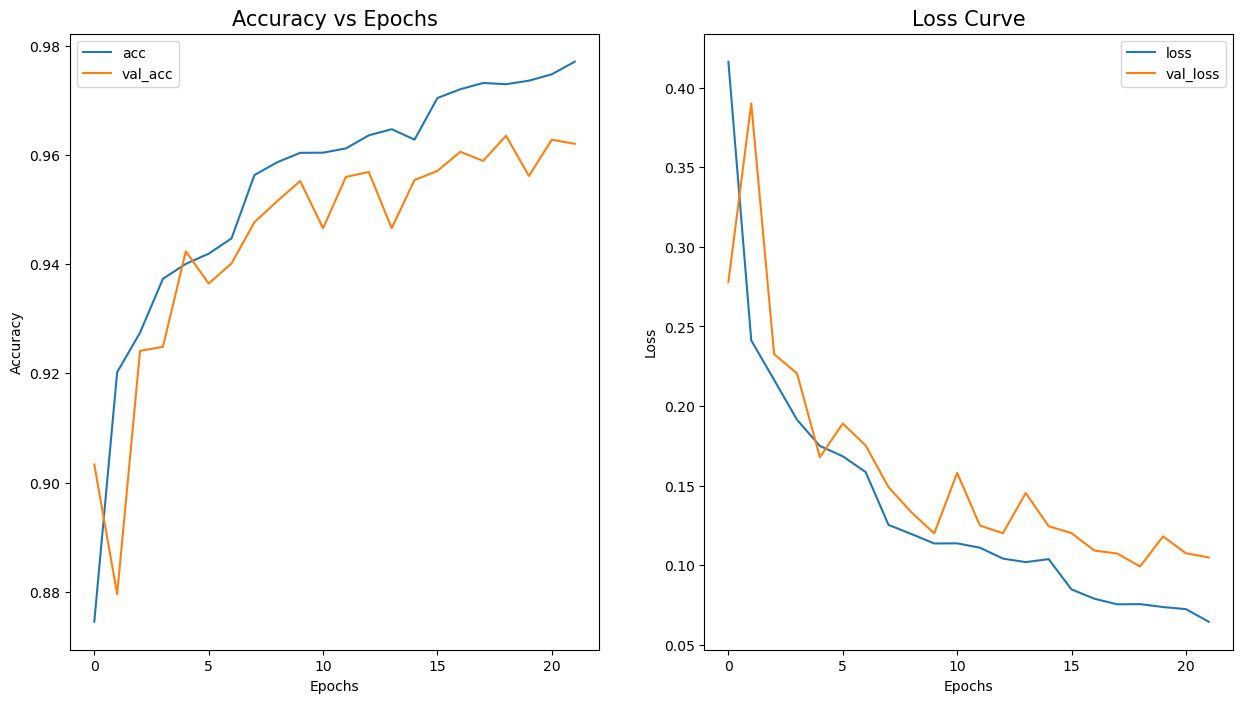

In [19]:
def model_performance_graphs(classifier):
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))

    axes[0].plot(classifier.epoch, classifier.history["acc"], label="acc")
    axes[0].plot(classifier.epoch, classifier.history["val_acc"], label="val_acc")
    axes[0].set_title("Accuracy vs Epochs", fontsize=15)
    axes[0].set_xlabel("Epochs", fontsize=10)
    axes[0].set_ylabel("Accuracy", fontsize=10)
    axes[0].legend()

    axes[1].plot(classifier.epoch, classifier.history["loss"], label="loss")
    axes[1].plot(classifier.epoch, classifier.history["val_loss"], label="val_loss")
    axes[1].set_title("Loss Curve",fontsize=15)
    axes[1].set_xlabel("Epochs",fontsize=10)
    axes[1].set_ylabel("Loss",fontsize=10)
    axes[1].legend()

    plt.show()
    
model_performance_graphs(classifier)

In [20]:
def input_visualizer(model, df, random_number):
    
    layer_names = [layer.name for layer in model.layers]
    layer_outputs = [layer.output for layer in model.layers]
    
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    img = cv2.imread(test_df["image_filepaths"][df.index[random_number]])
    img = img.reshape(-1, CONFIG.IMAGE_SHAPE[0], CONFIG.IMAGE_SHAPE[1], CONFIG.IMAGE_SHAPE[2]) / 255.0

    activations = activation_model.predict(img, verbose=0)
    
    for number in range(1):
        fig = plt.figure(figsize=(22, 3))
        for i in range(30):
            ax = fig.add_subplot(2, 15, i + 1)
            ax = plt.imshow(activations[number][0, :, :, ...])
            main_title = fig.suptitle(str(layer_names[number]), fontsize=20)
            plt.xticks([])
            plt.yticks([])
            fig.subplots_adjust(wspace=0.05, hspace=0.05)        
    
    return activations, layer_names

In [21]:
def visualize_intermediate_activations(activations, layer_names):

    assert len(layer_names) == len(activations)
    images_per_row = 16
    
    for layer_name, layer_activation in zip(layer_names, activations):
        nb_features = layer_activation.shape[-1]
        size= layer_activation.shape[1]

        nb_cols = nb_features // images_per_row
        grid = np.zeros((size * nb_cols, size * images_per_row))

        for col in range(nb_cols):
            for row in range(images_per_row):
                feature_map = layer_activation[0, :, :, col * images_per_row + row]
                feature_map -= feature_map.mean()
                feature_map /= feature_map.std()
                feature_map *= 255
                feature_map = np.clip(feature_map, 0, 255).astype(np.uint8)

                grid[col * size: (col + 1) * size, row * size: (row + 1) * size] = feature_map

        scale = 1. / size
        plt.figure(figsize=(scale * grid.shape[1], scale * grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(grid, aspect="auto")
        
    plt.show()

In [22]:
# random_number = random.randint(0, len(test_df))
# activations, layer_names = input_visualizer(transfer_learning_model, test_df, random_number)
# activations.pop(0)
# layer_names.pop(0)
# visualize_intermediate_activations(activations, layer_names)

In [23]:
tf.keras.backend.clear_session()
model = tf.keras.models.load_model(f"../working/{CONFIG.MODEL_NAMES[-1]}_epochs_{CONFIG.EPOCHS}_batchsize_{CONFIG.BATCH_SIZE}_lr_{CONFIG.LEARNING_RATE}.h5")
# model = tf.keras.models.load_model("/kaggle/input/plant-disease-mini-project-trained-models/inceptionv3_epochs_25_batchsize_128_lr_0.001.h5")

In [24]:
test_set_results = model.evaluate_generator(test_generator, verbose=0)
print(f"Loss: {test_set_results[0]}\nTest Set Accuracy: {test_set_results[1] * 100} %")

Loss: 0.08438228070735931
Test Set Accuracy: 97.20125198364258 %


In [25]:
y_pred = []

for image_filepath in test_df["image_filepaths"]:
    img = cv2.imread(image_filepath)
    img = img.reshape(-1, CONFIG.IMAGE_SHAPE[0], CONFIG.IMAGE_SHAPE[1], CONFIG.IMAGE_SHAPE[2]) / 255.0
    pred = model.predict(img, verbose=0)
    final_label = np.argmax(pred, axis=1)
    y_pred.append(final_label)

print(len(y_pred))
y_pred = np.array(y_pred)
y_pred = y_pred.flatten()
y_pred

5431


array([ 9, 10, 30, ..., 33, 28, 29])

In [26]:
y_true = []

for label in test_df["labels"]:
    y_true.append(test_generator.class_indices[label])
    
y_true = np.array(y_true).flatten()
print(len(y_true))
y_true

5431


array([10, 10, 30, ..., 33, 28, 29])

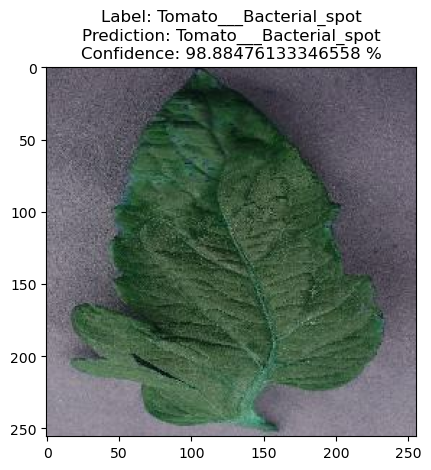

In [27]:
def show_image_predictions(test_df, random_number):
    
    original_img = cv2.imread(test_df["image_filepaths"][test_df.index[random_number]])
    label = test_df["labels"][test_df.index[random_number]]
    img = original_img.reshape(-1, CONFIG.IMAGE_SHAPE[0], CONFIG.IMAGE_SHAPE[1], CONFIG.IMAGE_SHAPE[2]) / 255.0
    pred = model.predict(img, verbose=0)
    confidence = pred.max()
    pred = np.argmax(pred, axis=1)[0]
    pred = [i for i in test_generator.class_indices if int(test_generator.class_indices[i]) == pred]
    plt.title(f"Label: {label}\nPrediction: {pred[0]}\nConfidence: {confidence * 100} %")
    plt.imshow(original_img)
    plt.show()
    
show_image_predictions(test_df, random.randint(0, len(test_df)))

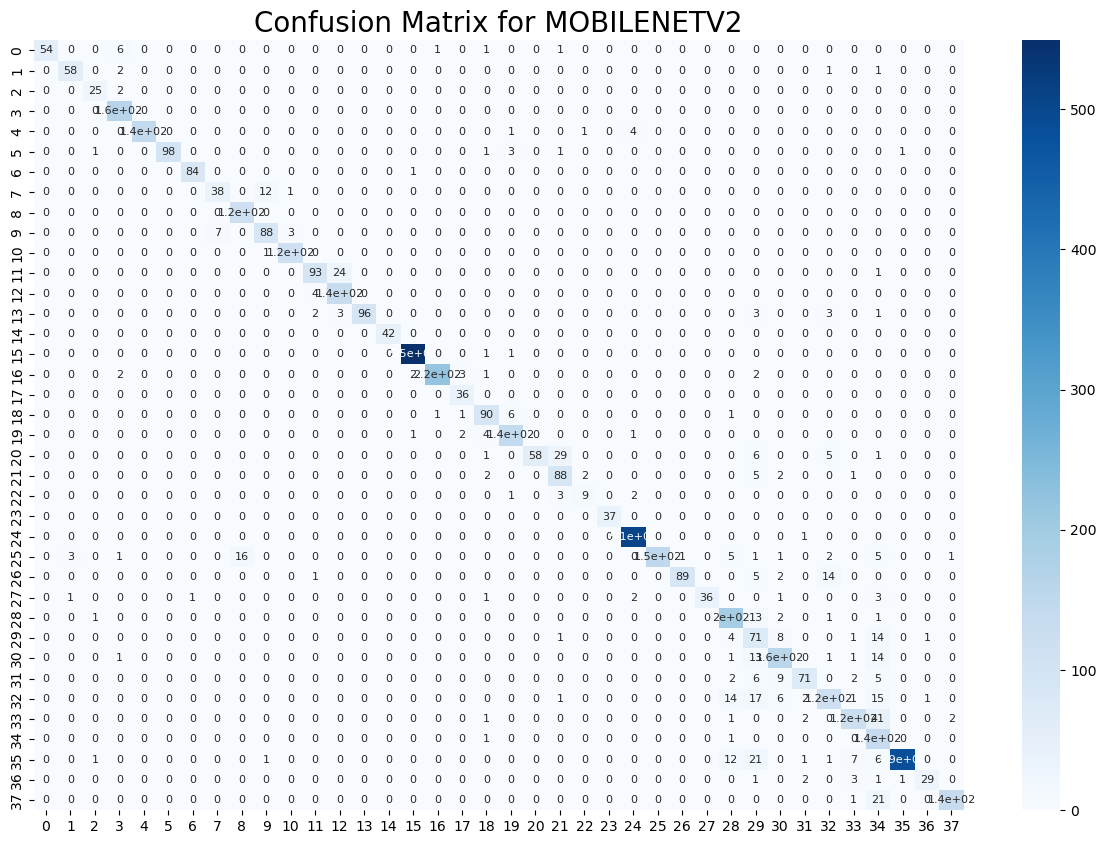

In [28]:
def plot_confusion_matrix(y_true, y_pred, model_name):

    plt.figure(figsize=(15, 10))
    sns.heatmap(confusion_matrix(y_true, y_pred), cmap="Blues", annot=True, annot_kws={"size": 8})
    plt.title(f"Confusion Matrix for {model_name.upper()}", fontsize=20)
    plt.show()
    
plot_confusion_matrix(y_true, y_pred, CONFIG.MODEL_NAMES[-1])

In [29]:
def get_model_results(y_true, y_pred, test_set_results, model_name):
    
    print(10 * "=", f"For {model_name.title()}", 10 * "=")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted')}")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted')}")
    print(f"F1-Score: {f1_score(y_true, y_pred, average='weighted')}")

get_model_results(y_true, y_pred, test_set_results, CONFIG.MODEL_NAMES[-1])

========== For Mobilenetv2 ==========
Precision: 0.9198380103222542
Recall: 0.900754925428098
F1-Score: 0.9042404315787425
